---
# Size response curves

This notebook aims to find stimulus sizes that allow optimal disentanglement of pRFs in superficial/deep layers and middle layers of the cortex. We know from earlier studies that pRF-sizes seem to be higher in superficial and deeper layers compared to middle layer pRFs. Here, we take for each subject the Gaussian pRF parameters, fit a Divisive Normalization model, compare the Size-Response curves for superficial/deeper layers (= `regular` pRF size) and middle layers (= `0.8*pRF-size`), and extract the stimulus sizes where the differences between these to curves are largest

Goals:
- Test `linescanning.utils.CollectSubject`-class
- Test `linescanning.utils.LazyPlot` with specific axes of `gridspec`
- Fit DN-model to single timeseries (`linescanning.prf.pRFmodelFitting`)
- Test `linescanning.prf.SizeResponse`-class for size-response curves and other related functions

EDIT: All of this is now embedded in `linescanning/bin/call_sizeresponse`

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from prfpy import *
from linescanning import *
from linescanning import prf,utils
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import warnings
import os

warnings.filterwarnings('ignore')

opj = os.path.join

base_dir = os.environ['DIR_DATA_HOME']
print(base_dir)
fig_dir = opj(base_dir, 'code', 'figures', 'prf')


/home/heij/.conda/envs/mpl/lib/python3.10/site-packages/nilearn/datasets/__init__.py:93: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "
/home/heij/.conda/envs/mpl/lib/python3.10/site-packages/nilearn/glm/__init__.py:55: FutureWarning: The nilearn.glm module is experimental. It may change in any future release of Nilearn.
  warn('The nilearn.glm module is experimental. '


/data1/projects/MicroFunc/Jurjen/projects/hemifield


--------------------------------------------------------------------------------------------------------------------


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.5s finished


sub-001
  params in: 	[ 1.785 -2.457  0.234  0.    -0.236  0.716]
  params out: 	[ 1.785 -2.457  0.234  2.45  -0.124  0.01  18.     2.45  10.     0.78 ]
im here
im here


findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


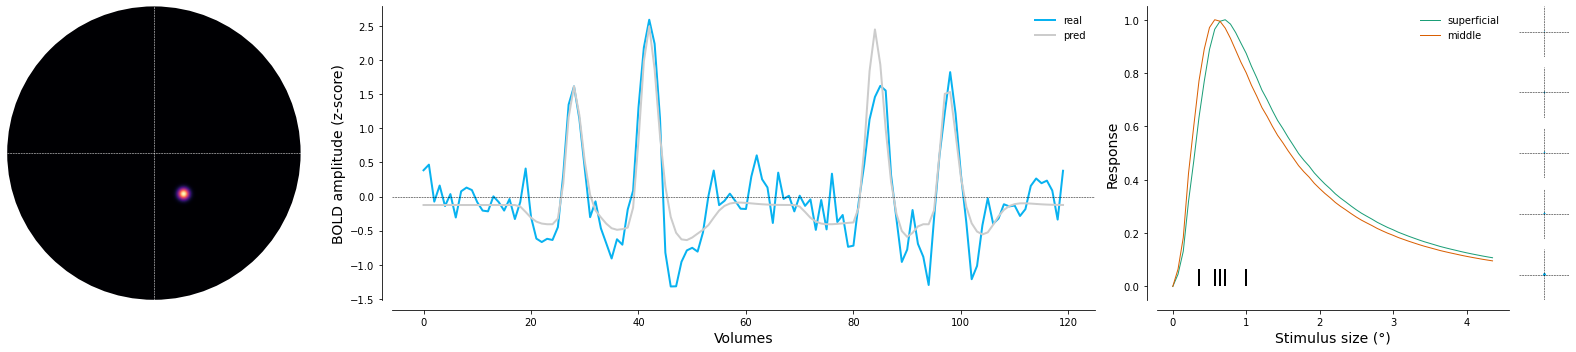

In [3]:
# general settings
subj_list = ['sub-001', 'sub-002', 'sub-003', 'sub-004', 'sub-005', 'sub-006', 'sub-007', 'sub-008', 'sub-009']
# subj_list = ['sub-001'] #, 'sub-006']
hemi = "lh"
line_width = 2

for idx,subject in enumerate(subj_list):

    print("--------------------------------------------------------------------------------------------------------------------")

    prfdir = opj(base_dir, 'derivatives', 'prf', subject, 'ses-1')
    cxdir = opj(base_dir, 'derivatives', 'pycortex', subject)

    fig = plt.figure(constrained_layout=True, figsize=(30,5))
    gs00 = fig.add_gridspec(1,4, width_ratios=[10,20,10,10])
    gs01 = fig.add_gridspec(5,1, left=0.48, right=0.98)

    if hemi == "lh":
        hemi_tag = "hemi-L"
    elif hemi == "rh":
        hemi_tag = "hemi-R"

    # Collect subject-relevant information in class
    subject_info = utils.CollectSubject(subject, prf_dir=prfdir, cx_dir=cxdir, settings='recent', hemi=hemi)

    # make plot and increment counter
    ax1 = fig.add_subplot(gs00[0])
    prf.plot_prf(subject_info.prf_array, subject_info.settings['vf_extent'], ax=ax1)

    # Get and plot fMRI signal
    data_fn = utils.get_file_from_substring(f"avg_bold_{hemi_tag}.npy", subject_info.prf_dir)
    if data_fn != None:
        data = np.load(data_fn)[...,subject_info.return_target_vertex(hemi=hemi)]
    else:
        raise ValueError(f"Could not find file with '{hemi_tag}.npy' in {subject_info.prf_dir}")
    
    # do DN-model fit
    # define model
    if 'd' not in list(subject_info.vert_info.data.reset_index().keys()):
        
        # insert old parameters
        insert_params =(np.array(subject_info.target_params)[np.newaxis,...],"gauss+iter")

        # initiate class
        fitting = prf.pRFmodelFitting(data[...,np.newaxis].T, 
                                      design_matrix=subject_info.design_matrix, 
                                      TR=subject_info.settings['TR'], 
                                      model="norm", 
                                      stage="grid", 
                                      old_params=insert_params, 
                                      verbose=False, 
                                      output_dir=subject_info.prf_dir, 
                                      nr_jobs=1)
        
        # fit
        fitting.fit()

        new_params = fitting.norm_grid[0]
        print(f"{subject}")
        print(f"  params in: \t{np.array(subject_info.target_params)}")
        print(f"  params out: \t{new_params}")
        new_prediction = fitting.norm_model.return_prediction(*new_params[:-1]).T

        # make plot and increment counter
        ax2 = fig.add_subplot(gs00[1])
        utils.LazyPlot([data, new_prediction], 
                       color=['#08B2F0','#cccccc'], 
                       labels=['real','pred'], 
                       add_hline='defaults', 
                       line_width=2,
                       axs=ax2,
                       y_label="BOLD amplitude (z-score)",
                       x_label="Volumes",
                       font_size=14)

        # size response functionsf
        SR = prf.SizeResponse(fitting.prf_stim, new_params)
        SR.make_stimuli()
        sr_curve1 = SR.make_sr_function(center_prf=True)
        sr_curve2 = SR.make_sr_function(center_prf=True, scale_factor=0.8)

        # make plot 
        ax3 = fig.add_subplot(gs00[2])
        utils.LazyPlot([sr_curve1, sr_curve2], 
                        xx=SR.stims_fill_sizes,
                        color=["#1B9E77","#D95F02"], 
                        labels=['superficial', 'middle'],
                        axs=ax3,
                        y_label="Response",
                        x_label="Stimulus size (°)",
                        font_size=14)

        # find stim sizes
        use_stim_sizes = SR.find_stim_sizes(sr_curve1, sr_curve2)
        for ix,ii in enumerate(use_stim_sizes):
            ax3.axvline(ii, color='k', lw=2, ymin=0.05, ymax=0.1)

            # plot actual stimuli too
            ax = fig.add_subplot(gs01[ix])
            stim_ix = utils.find_nearest(SR.stims_fill_sizes, ii)[0]
            cmap_blue = utils.make_binary_cm((8,178,240))

            im = ax.imshow(SR.stims_fill[stim_ix], extent=subject_info.settings['vf_extent']+subject_info.settings['vf_extent'], cmap=cmap_blue)
            ax.axvline(0, color='k', linestyle='dashed', lw=0.5)
            ax.axhline(0, color='k', linestyle='dashed', lw=0.5)
            ax.axis('off')
            patch = patches.Circle((0,0), radius=subject_info.settings['vf_extent'][-1], transform=ax.transData)
            im.set_clip_path(patch)

        fig.tight_layout(rect=[0, 0, 0.91, 1])